### The training and evaluation of a cell-based NARVAL R2B4 model

This notebook is a quickly illustrates the process of training and evaluating a cell-based neural network based cloud cover parameterization.<br> We train and evaluate the neural network on coarse-grained and preprocessed NARVAL R2B4 data. In this notebook, we work with data that is already prepared for this purpose.

In [1]:
# Importing necessary packages
import sys
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Print options for pandas
pd.options.display.float_format = "{:,.2g}".format

# Reloading custom file to incorporate changes dynamically
import importlib
import my_classes
importlib.reload(my_classes)

# Data path
path = '/pf/b/b309170'
path_data = path + '/workspace_icon-ml/iconml_clc/extract_from_the_data/coarse-grained_and_preprocessed/narval_r2b4_cell_based'

# Stop training after how many minutes.
# We decreased the training time for this notebook to an hour.
from my_classes import TimeOut
t0 = time.time()
timeout = 60 

# Random seed
NUM = 1 
tf.random.set_seed(NUM)

# List GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

#### Loading the data
**Input-variables:**
- *fr_land*: Fraction of land 
- *z_g*: Geometric height at full levels
- *q_v*: Specific water vapor content
- *q_i*: Specific cloud ice content
- *temp*: Temperature
- *pres*: Pressure

**Output-variables:**
- *clc*: Cloud cover (cloud volume fraction)

In [2]:
# Load coarse-grained and preprocessed data
input_train = np.load(path_data + '/cloud_cover_all_days_input_train.npy')
input_valid = np.load(path_data + '/cloud_cover_all_days_input_valid.npy')
input_test = np.load(path_data + '/cloud_cover_all_days_input_test.npy')
output_train = np.load(path_data + '/cloud_cover_all_days_output_train.npy')
output_valid = np.load(path_data + '/cloud_cover_all_days_output_valid.npy')
output_test = np.load(path_data + '/cloud_cover_all_days_output_test.npy')

In [3]:
print('The training data consists of %d training samples.'%input_train.shape[0])
print('The validation data consists of %d validation samples.'%input_valid.shape[0])
print('The test data consists of %d test samples.'%input_test.shape[0])

print('We have %d input features for the neural network.'%input_train.shape[1])
assert input_train.shape[1] == input_valid.shape[1] == input_test.shape[1]

The training data consists of 26482169 training samples.
The validation data consists of 2942463 validation samples.
The test data consists of 7356158 test samples.
We have 6 input features for the neural network.


#### Looking at the data

The corresponding means, standard deviations and features can be found in: <br>
/n1_cell_based_narval_r2b4/saved_models/model_grid_cell_based_v3_final_1.txt

In [4]:
features = ['qv', 'qi', 'temp', 'pres', 'zg', 'fr_land']
mean = np.array([5.37518440e-03, 4.65389731e-07, 2.59635412e+02, 5.52329389e+04, 6.79260772e+03, 2.58097095e-01])
std = np.array([6.01943993e-03, 3.95009930e-06, 3.55940285e+01, 3.26642242e+04, 6.20726361e+03, 4.28313535e-01])

In [5]:
# Looking at the data. It is already normalized.
pd.DataFrame(input_train, columns=features).describe()

,qv,qi,temp,pres,zg,fr_land
count,2.6e+07,2.6e+07,2.6e+07,2.6e+07,2.6e+07,2.6e+07
mean,2e-16,1.1e-16,-1.2e-14,3e-15,1.5e-16,1.1e-15
std,1,1,1,1,1,1
min,-0.89,-0.12,-2.1,-1.5,-1.1,-0.6
25%,-0.88,-0.12,-0.86,-0.94,-0.88,-0.6
50%,-0.5,-0.12,0.38,0.11,-0.35,-0.6
75%,0.95,-0.12,0.87,0.98,0.68,1.3
max,2.5,2.4e+02,1.6,1.4,2.3,1.7


In [6]:
# The validation/test data is normalized w.r.t. the training data, so e.g. the means are also close to zero
assert 1e-3 < np.sum(np.abs(input_valid.mean(axis=0))) < 1e-2
assert 1e-3 < np.sum(np.abs(input_test.mean(axis=0))) < 1e-2

In [7]:
# Reverse scaling to look at the original data
pd.DataFrame((input_train*std)+mean, columns=features).describe()

,qv,qi,temp,pres,zg,fr_land
count,2.6e+07,2.6e+07,2.6e+07,2.6e+07,2.6e+07,2.6e+07
mean,0.0054,4.7e-07,2.6e+02,5.5e+04,6.8e+03,0.26
std,0.006,4e-06,36,3.3e+04,6.2e+03,0.43
min,1.2e-06,-1.3e-16,1.9e+02,4.8e+03,20,1.1e-10
25%,6e-05,-1.3e-16,2.3e+02,2.5e+04,1.3e+03,1.1e-10
50%,0.0024,-1.2e-16,2.7e+02,5.9e+04,4.6e+03,1.1e-10
75%,0.011,6e-16,2.9e+02,8.7e+04,1.1e+04,0.82
max,0.021,0.00095,3.2e+02,1e+05,2.1e+04,1


#### The neural network

In [8]:
# Set up the neural network
model = Sequential()
model.add(Dense(256, activation='relu', input_dim = 6))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 67,841
Trainable params: 67,841
Non-trainable params: 0
_________________________________________________________________


**Here, we train the neural network**

In [9]:
model.compile(loss='mse', optimizer=Nadam())
# Incorporates early stopping, i.e. the weights from the best concluded epoch are used
time_callback = TimeOut(t0, timeout) 
# We increase the batch size from 32 (in the paper) to 512 to require much less time per epoch
history = model.fit(input_train, output_train, batch_size=512, epochs=70, verbose=1,
                    validation_data=(input_valid, output_valid), callbacks=[time_callback])

Starting training
Epoch 1/70
51723/51723 [==============================] - 243s 5ms/step - loss: 27.5949 - val_loss: 18.3962
Epoch 2/70
51723/51723 [==============================] - 238s 5ms/step - loss: 18.3481 - val_loss: 18.2304
Epoch 3/70
51723/51723 [==============================] - 241s 5ms/step - loss: 17.6708 - val_loss: 17.8188
Epoch 4/70
51723/51723 [==============================] - 248s 5ms/step - loss: 17.3494 - val_loss: 17.4409
Epoch 5/70
51723/51723 [==============================] - 237s 5ms/step - loss: 17.1172 - val_loss: 16.7895
Epoch 6/70
51723/51723 [==============================] - 242s 5ms/step - loss: 16.9198 - val_loss: 16.5442
Epoch 7/70
51723/51723 [==============================] - 241s 5ms/step - loss: 16.7319 - val_loss: 16.9072
Epoch 8/70
51723/51723 [==============================] - 243s 5ms/step - loss: 16.5933 - val_loss: 16.2358
Epoch 9/70
51723/51723 [==============================] - 241s 5ms/step - loss: 16.4655 - val_loss: 16.3494
Epoch 10/7

**Let's look at how the training proceeded**

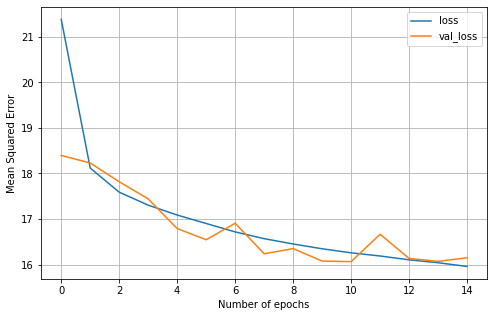

In [10]:
#Plotting the training progress
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of epochs')
plt.show()

**We evaluate the mean-squared errors on the training/validation/test sets** <br>
In the paper, we have MSEs of around 15 for the cell-based NARVAL R2B4 model

In [12]:
train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=2000)
valid_loss = model.evaluate(input_valid, output_valid, verbose=2, batch_size=1000)
test_loss = model.evaluate(input_test, output_test, verbose=2, batch_size=1000)

print('\nTraining loss: %.4f'%(train_loss))
print('Validation loss: %.4f'%(valid_loss))
print('Test loss: %.4f'%(test_loss))
print('Training epochs: %d'%(len(history.history['val_loss'])))

13242/13242 - 23s - loss: 15.9891
2943/2943 - 4s - loss: 16.0633
7357/7357 - 11s - loss: 16.0345

Training loss: 15.9891
Validation loss: 16.0633
Test loss: 16.0345
Training epochs: 15


#### Evaluation of the neural network

In the data we have just worked with (input_train, input_valid, input_test), where we do not know the vertical layer of the data samples. <br> We cannot use that data to evaluate the neural networks using vertical profiles in this example. <br> What we thus did was to load the NARVAL R2B4 data and to store it as an npy file (which saves space) in /extract_from_the_data/narval_r2b4_data_for_the_quickstart.npy

In [ ]:
# # We ran this cell once:

# from my_classes import load_data

# # Loads the NARVAL data into the data_dict dictionary
# order_of_vars=['qv', 'qi', 'temp', 'pres', 'zg', 'fr_land', 'clc']
# data_dict = load_data(source='narval', days='all', vert_interp=True, order_of_vars=order_of_vars)

# #Reshaping into nd-arrays of equaling shapes (have timesteps x vert x hor)
# data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), data_dict['qv'].shape[0], axis=0)
# data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), data_dict['qv'].shape[0], axis=0)
# data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 1), data_dict['qv'].shape[1], axis=1)

# assert data_dict['fr_land'].shape == data_dict['qv'].shape == data_dict['zg'].shape

# # Convert data_dict into numpy file and save as npy. We cannot take more than 54 time steps due to size limits on GitHub.
# np_arr = np.array([data_dict[key][:54] for key in data_dict.keys()])
# np.save('./extract_from_the_data/narval_r2b4_data_for_the_quickstart.npy', np_arr)

**First evaluation method** <br>
Samples on x-axis and cloud cover on y-axis. This we can do without knowing which vertical layer corresponds to a data sample.

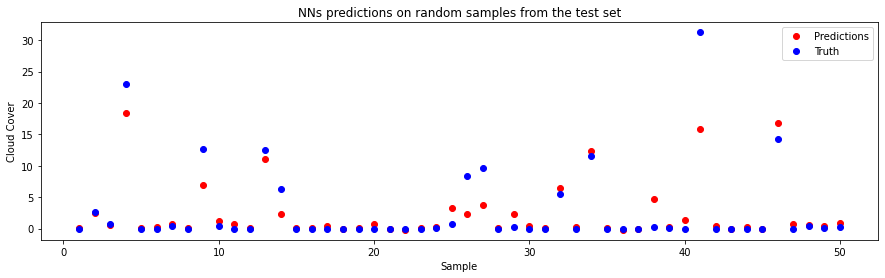

In [7]:
no_samples = 50
clc_pred = model.predict(input_test[:no_samples])[:,0]
clc_true = output_test[:no_samples]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111, title='NNs predictions on random samples from the test set', 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred, 'ro')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Truth'])

**Second evaluation method** <br>
Mean profile of Cloud Cover on x-axis with Vertical Layer on y-axis <br>
Here, I'm taking only the first 54 time steps of the NARVAL R2B4 data.

In [13]:
# Load and scale the data
np_arr = np.load('./extract_from_the_data/narval_r2b4_data_for_the_quickstart.npy')
scaled_data = np.array([(np_arr[i] - mean[i])/std[i] for i in range(len(features))])
scaled_data = np.append(scaled_data, np_arr[-1:], axis=0) # Add cloud cover
# Removes data above 21 km
scaled_data = scaled_data[:,:,4:,:]
scaled_data.shape # features x time steps x vertical layers x horizontal fields

(7, 54, 27, 1024)

In [24]:
# Predicted cloud cover mean per vertical layer
clc_pred_mean = []
for v_layer in range(21, 48):
    pred = np.transpose(model.predict_on_batch(np.transpose(scaled_data[:-1,:,v_layer-21,:])))
    pred_adj = np.minimum(np.maximum(pred, 0), 100)
    clc_pred_mean.append(np.mean(pred_adj))
    
# Cloud cover mean in the data
clc_data_mean = np.mean(scaled_data[-1], axis=(0, 2))

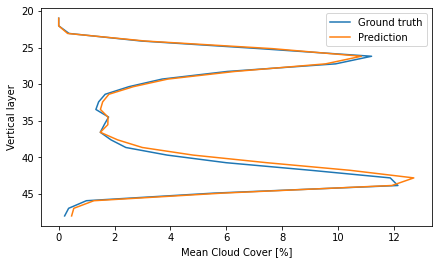

In [30]:
# Plot mean cloud cover per vertical layer
a = np.linspace(21, 48, 27)
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, xlabel='Mean Cloud Cover [%]', ylabel='Vertical layer')
ax.plot(clc_data_mean, a)
ax.plot(clc_pred_mean, a)
plt.gca().invert_yaxis()
ax.legend(['Ground truth', 'Prediction'])

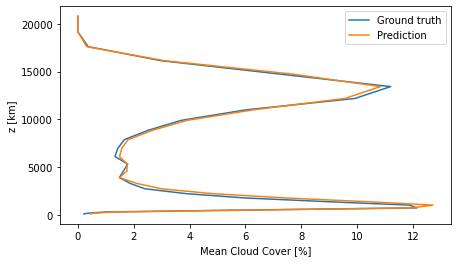

In [31]:
zg_mean = np.mean(np_arr[np.where([features[i] == 'zg' for i in range(len(features))])[0][0], :, 4:, :], axis=(0,2))

# Plot mean cloud cover per averaged height
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, xlabel='Mean Cloud Cover [%]', ylabel='z [km]')
ax.plot(clc_data_mean, zg_mean)
ax.plot(clc_pred_mean, zg_mean)
ax.legend(['Ground truth', 'Prediction'])

**Third visualization method** <br>
R2-value on x-axis with vertical layers on y-axis <br>

In [38]:
# r2 = 1-MSE/VAR
r2 = []
for v_layer in range(23, 48):
    pred = np.transpose(model.predict_on_batch(np.transpose(scaled_data[:-1,:,v_layer-21,:])))
    pred_adj = np.minimum(np.maximum(pred, 0), 100)
    
    mse = np.mean((pred_adj - scaled_data[-1, :, v_layer-21, :])**2)
    var = np.var(scaled_data[-1, :, v_layer-21, :])
    r2.append(1-mse/var)

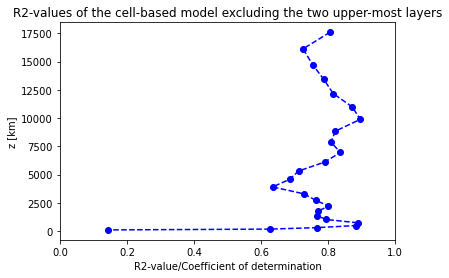

In [41]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, xlim=(0, 1), title='R2-values of the cell-based model excluding the two upper-most layers',
                     xlabel='R2-value/Coefficient of determination', ylabel='z [km]')
ax.plot(r2, zg_mean[2:], 'bo', ls='--')